# VQE energy of $H_2$ at varying bond lengths

This notebook is a continuation of the last, where we extend our analysis of VQE $H_2$ for different bond lengths. What we see is the familiar potential energy curve of bonding atoms. It is important that we include one more ingredient to make this curve and that is the nuclear repulsion energy of the two $H$ atoms. Without this term, the electronic attraction would increase until the two atoms fused, rather than settling at a minimum energy at some finite bond length.

In [102]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper

from qiskit.circuit.library import efficient_su2
from qiskit_ibm_runtime import EstimatorV2 as Estimator

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

from qiskit_ibm_runtime.fake_provider import FakeManilaV2

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from scipy.optimize import minimize

In [103]:
def get_qubit_hamiltonian(bond_length):

    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {bond_length}",
        basis="sto6g",
    )

    problem = driver.run()
    fermionic_op = problem.hamiltonian.second_q_op()
    nuclear_repulsion = problem.nuclear_repulsion_energy

    mapper = JordanWignerMapper()
    qubit_op = mapper.map(fermionic_op)

    return qubit_op, nuclear_repulsion

In [104]:
def transpile_ansatz(ansatz, hamiltonian, backend):

    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)
    ansatz_isa = pm.run(ansatz)

    h2_hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

    return h2_hamiltonian_isa, ansatz_isa

In [105]:
def optimize_ansatz(ansatz_isa, hamiltonian, backend):

    def cost_func(params, ansatz, hamiltonian, estimator, cost_history_dict):

        pub = (ansatz, [hamiltonian], [params])
        result = estimator.run(pubs=[pub]).result()
        electronic_energy = result[0].data.evs[0]


        cost_history_dict["iters"] += 1
        cost_history_dict["cost_history"].append(electronic_energy)

        print(
            f"Iters: {cost_history_dict['iters']} | "
            f"Electronic energy: {electronic_energy:.6f} | "
        )

        return electronic_energy 

    cost_history_dict = {
        "iters": 0,
        "cost_history": [],
    }

    noise_model = NoiseModel.from_backend(backend)
    backend_sim = AerSimulator(noise_model=None)

    estimator = Estimator(backend_sim)
    estimator.options.default_shots = 10000

    iterations = 50

    x0 = [0] * len(ansatz_isa.parameters)
    x0[0] = 2

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian, estimator, cost_history_dict),
        method="cobyla",
        options={"maxiter": iterations},
    )

    return res, cost_history_dict

In [106]:
def vqe(h2_hamiltonian, ansatz):

    fake_backend = FakeManilaV2()

    hamiltonian_isa, ansatz_isa = transpile_ansatz(
        ansatz=ansatz,
        hamiltonian=h2_hamiltonian,
        backend=fake_backend
    )

    res, cost_history_dict = optimize_ansatz(
        ansatz_isa=ansatz_isa,
        hamiltonian=hamiltonian_isa,
        backend=fake_backend
    )

    return res, cost_history_dict

In [109]:
short_range = np.linspace(0.1, 1.0, 10, endpoint=False)
long_range = np.linspace(1.0, 10.0, 10)
bond_lengths = np.concatenate([short_range, long_range])

vqe_energies = []

for R in bond_lengths:

    print(f"\nRunning VQE for bond length: {R:.2f} Å")

    h2_hamiltonian, nuclear_repulsion = get_qubit_hamiltonian(R)

    ansatz = efficient_su2(
        4,
        su2_gates=["rx", "y"],
        entanglement="linear",
        reps=1
    )
    res, _ = vqe(h2_hamiltonian, ansatz)

    total_energy = res.fun + nuclear_repulsion

    vqe_energies.append(total_energy)


Running VQE for bond length: 0.10 Å
Iters: 1 | Electronic energy: -1.152922 | 
Iters: 2 | Electronic energy: -2.569633 | 
Iters: 3 | Electronic energy: -1.537233 | 
Iters: 4 | Electronic energy: -2.019806 | 
Iters: 5 | Electronic energy: -2.079767 | 
Iters: 6 | Electronic energy: -2.361736 | 
Iters: 7 | Electronic energy: -2.094108 | 
Iters: 8 | Electronic energy: -2.360534 | 
Iters: 9 | Electronic energy: -2.109173 | 
Iters: 10 | Electronic energy: -1.939453 | 
Iters: 11 | Electronic energy: -2.179531 | 
Iters: 12 | Electronic energy: -2.576403 | 
Iters: 13 | Electronic energy: -2.584261 | 
Iters: 14 | Electronic energy: -2.580877 | 
Iters: 15 | Electronic energy: -2.586128 | 
Iters: 16 | Electronic energy: -2.579247 | 
Iters: 17 | Electronic energy: -2.587922 | 
Iters: 18 | Electronic energy: -2.574837 | 
Iters: 19 | Electronic energy: -2.586428 | 
Iters: 20 | Electronic energy: -2.582071 | 
Iters: 21 | Electronic energy: -2.575004 | 
Iters: 22 | Electronic energy: -2.593990 | 
Iter

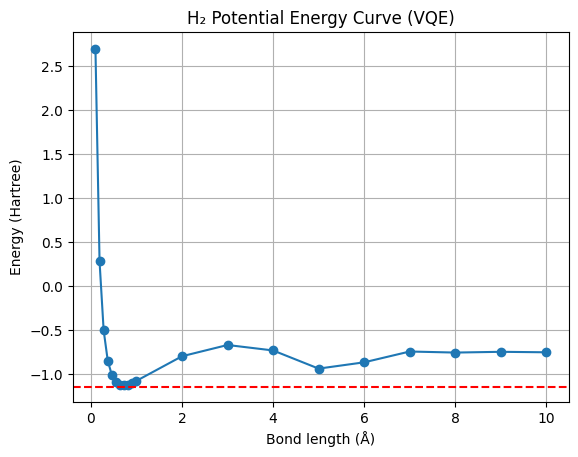

In [112]:
from qiskit.quantum_info import SparsePauliOp

q_op, nuc_rep = get_qubit_hamiltonian(0.735)
H = SparsePauliOp.from_list(q_op.to_list())
 
A = np.array(H)
eigenvalues, _ = np.linalg.eig(A)
h2 = min(eigenvalues).real + nuc_rep

plt.figure()
plt.plot(bond_lengths, vqe_energies, marker="o")
plt.axhline(h2, color='red', linestyle='--', label="Theoretical minimum")
plt.xlabel("Bond length (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("H₂ Potential Energy Curve (VQE)")
plt.grid()
plt.show()

# Single H atom

In [ ]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper

driver = PySCFDriver(
    atom="H 0 0 0",
    basis="sto6g",
    charge=0,
    spin=1,  # 1 unpaired electron
)

problem = driver.run()
fermionic_op = problem.hamiltonian.second_q_op()

mapper = JordanWignerMapper()
qubit_op = mapper.map(fermionic_op)

nuclear_repulsion = problem.nuclear_repulsion_energy

assert nuclear_repulsion == 0, "nuclear_repulsion should be 0"

In [97]:
small_ansatz = efficient_su2(
    2,
    su2_gates=["ry"],
    entanglement="linear",
    reps=1
)

In theory the ground state of $H$ should be about 0.5x the ground state of $H_2$ at large bond lengths (essentially two separate $H$ atoms). The reason we see some discrepancy is due to a shortcoming of our basis set when solving for $H_2$. The sto6g basis is a good choice at small bond lengths but too limited to accurately describe fully separated atoms at large bond lengths.

In [ ]:
res, _ = vqe(qubit_op, small_ansatz)

total_energy = res.fun + nuclear_repulsion

print("H atom ground state energy:", total_energy)

Iters: 1 | Electronic energy: -0.117925 | 
Iters: 2 | Electronic energy: -0.166077 | 
Iters: 3 | Electronic energy: -0.234617 | 
Iters: 4 | Electronic energy: -0.269820 | 
Iters: 5 | Electronic energy: -0.221791 | 
Iters: 6 | Electronic energy: -0.240820 | 
Iters: 7 | Electronic energy: -0.300810 | 
Iters: 8 | Electronic energy: -0.334397 | 
Iters: 9 | Electronic energy: -0.359244 | 
Iters: 10 | Electronic energy: -0.358147 | 
Iters: 11 | Electronic energy: -0.340285 | 
Iters: 12 | Electronic energy: -0.399022 | 
Iters: 13 | Electronic energy: -0.419067 | 
Iters: 14 | Electronic energy: -0.417729 | 
Iters: 15 | Electronic energy: -0.421408 | 
Iters: 16 | Electronic energy: -0.389418 | 
Iters: 17 | Electronic energy: -0.423860 | 
Iters: 18 | Electronic energy: -0.435439 | 
Iters: 19 | Electronic energy: -0.449858 | 
Iters: 20 | Electronic energy: -0.459047 | 
Iters: 21 | Electronic energy: -0.463939 | 
Iters: 22 | Electronic energy: -0.462868 | 
Iters: 23 | Electronic energy: -0.461603 